In [15]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.io_utils import load_multiple_res
from utils.pd_utils import compute_outlier_scores, transform_dgms, filter_dgms
from utils.fig_utils import full_dist_to_print, dist_to_color, dist_to_print
import os
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [16]:
style_file = "utils.style"
plt.style.use(style_file)

In [17]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Fig many methods on a toy circle

In [18]:
# hyperparameters

# hyperparameters which produce the best AUC per distance type
distances = {
    "euclidean": [{}],
    "fermat": [
               {"p": 3},
           ],
    "dtm": [
            {"k": 4, "p_dtm": 2, "p_radius": 1},
                    ],
    "core": [
        {"k": 15},
    ],
    "sknn_dist": [
        {"k": 100}
    ],
    "tsne": [
         {"perplexity": 30},
    ],
    "umap": [
         {"k": 100, "use_rho": True, "include_self": True},
    ],
    "tsne_embd": [
        {"perplexity": 30, "n_epochs": 500, "n_early_epochs": 250, "rescale_tsne": True},
    ],
    "umap_embd": [
        {"k": 15, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean"},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True},
        ],
    "diffusion":[
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
    ],
    "spectral": [
        {"k": 15, "normalization": "none", "n_evecs": 2, "weighted": False},
    ]
}

n = 1000
embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]

In [19]:
all_res = load_multiple_res(datasets="toy_circle", distances=distances, root_path=root_path, n=n, embd_dims=embd_dim, sigmas=sigmas, seeds=seeds, n_threads=10)

Done with toy_circle 50 euclidean n_outliers=0
Done with toy_circle 50 fermat_p_3 n_outliers=0
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0
Done with toy_circle 50 core_k_15 n_outliers=0
Done with toy_circle 50 sknn_dist_k_100 n_outliers=0
Done with toy_circle 50 tsne_perplexity_30 n_outliers=0
Done with toy_circle 50 umap_k_100_use_rho_True_include_self_True n_outliers=0
Done with toy_circle 50 tsne_embd_perplexity_30_n_epochs_500_n_early_epochs_250_rescale_tsne_True n_outliers=0
Done with toy_circle 50 umap_embd_k_15_n_epochs_750_min_dist_0.1_metric_euclidean n_outliers=0
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0
Done with toy_circle 50 diffusion_k_100_t_8_kernel_sknn_include_self_False n_outliers=0
Done with toy_circle 50 spectral_k_15_normalization_none_n_evecs_2_weighted_False n_outliers=0


In [20]:
# filtering
dob = 1.25
all_res = filter_dgms(all_res, dob=dob, dim=1, binary=True)

In [21]:
# compute outlier scores
outlier_scores = compute_outlier_scores(dgms=all_res, n_features=1, dim=1)

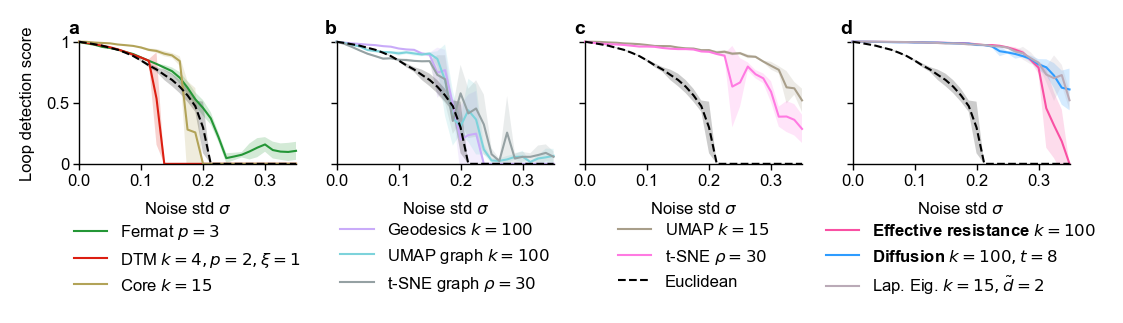

In [22]:
# plot figure
groups = [["fermat", "dtm", "core"], ["sknn_dist", "umap", "tsne"], ["umap_embd", "tsne_embd"], ["eff_res", "diffusion", "spectral"]]
panel_labels = ["Density-based", "Graph-based", "Embedding-based", "Spectral"]
letters = "abcd"

fig, ax = plt.subplots(ncols=len(groups),
                       figsize=(5.5, 1.5))


mean_eucl = outlier_scores["euclidean"]["euclidean"].mean(1)
std_eucl = outlier_scores["euclidean"]["euclidean"].std(1)


for i, group in enumerate(groups):
    for distance in group:
        for full_dist in outlier_scores[distance]:
            mean = outlier_scores[distance][full_dist].mean(1)
            std = outlier_scores[distance][full_dist].std(1)
                       
            ax[i].plot(sigmas,
                       mean ,
                       label=full_dist_to_print[full_dist].replace("\n", " "),
                       c=dist_to_color[distance],
                       clip_on=False
            )
            ax[i].fill_between(sigmas,
                               mean+std,
                               mean-std,
                               alpha=0.2,
                               #color=full_dist_to_color[full_dist],
                               color=dist_to_color[distance],
                               edgecolor=None
                               )

    if i==2:
        ax[i].plot(sigmas, 
                   mean_eucl, 
                   c="k", 
                   linestyle="dashed", 
                   #label=full_dist_to_print["euclidean"], 
                   label=dist_to_print["euclidean"], 
                   clip_on=False)
    else:
                ax[i].plot(sigmas, mean_eucl, c="k", linestyle="dashed", clip_on=False)

    ax[i].fill_between(sigmas,
                       mean_eucl+std_eucl,
                       mean_eucl-std_eucl,
                       color="k",
                       alpha=0.2,
                       edgecolor=None)
    
        
        
        
    legend = ax[i].legend(loc='upper center',
                 bbox_to_anchor=(0.5, -0.35),
                 frameon=False
          )
    
    if i == 3:
        leg_labels = legend.get_texts()
        leg_labels[0].set_weight("bold")
        leg_labels[1].set_weight("bold")
    
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, 0.35)
    ax[i].set_xlabel("Noise std $\sigma$")
    if i==0:
        ax[i].set_ylabel("Loop detection score")
        
    if i > 0:
        ax[i].set_yticklabels([])
    else:
        ax[i].set_yticks([0, 0.5, 1])
        ax[i].set_yticklabels([0, 0.5, 1])
        
    #ax[i].set_title(panel_labels[i])
    ax[i].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)
    
fig.savefig(os.path.join(fig_path, "fig_toy_circle_dob.pdf"))

# Fig eff res on circle

In [23]:
distances = {
    "euclidean": [{}],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True},
        {"corrected": True, "weighted": True, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": True, "k": 100, "disconnect": True},
        {"corrected": False, "weighted": True, "k": 15, "disconnect": True},
        {"corrected": False, "weighted": True, "k": 100, "disconnect": True},

    ],

}

n = 1000
embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]

In [24]:
all_res = load_multiple_res(datasets="toy_circle", distances=distances, root_path=root_path, n=n, embd_dims=embd_dim, sigmas=sigmas, seeds=seeds, n_threads=10)

Done with toy_circle 50 euclidean n_outliers=0
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_15_disconnect_True n_outliers=0
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0
Done with toy_circle 50 eff_res_corrected_True_weighted_True_k_15_disconnect_True n_outliers=0
Done with toy_circle 50 eff_res_corrected_True_weighted_True_k_100_disconnect_True n_outliers=0
Done with toy_circle 50 eff_res_corrected_False_weighted_True_k_15_disconnect_True n_outliers=0
Done with toy_circle 50 eff_res_corrected_False_weighted_True_k_100_disconnect_True n_outliers=0


In [25]:
# take square root of birth and death times to obtain the diagram corresponding to squared eff res
for dist in list(all_res["eff_res"])[:2]:
    all_res["eff_res"][dist+"_sqrt"] = transform_dgms(all_res["eff_res"][dist], transformation="sqrt")

In [26]:
# filtering
dob = 1.25
all_res = filter_dgms(all_res, dob=dob, dim=1, binary=True)

In [27]:
# compute detection scores
outlier_scores = compute_outlier_scores(dgms=all_res, n_features=1, dim=1)

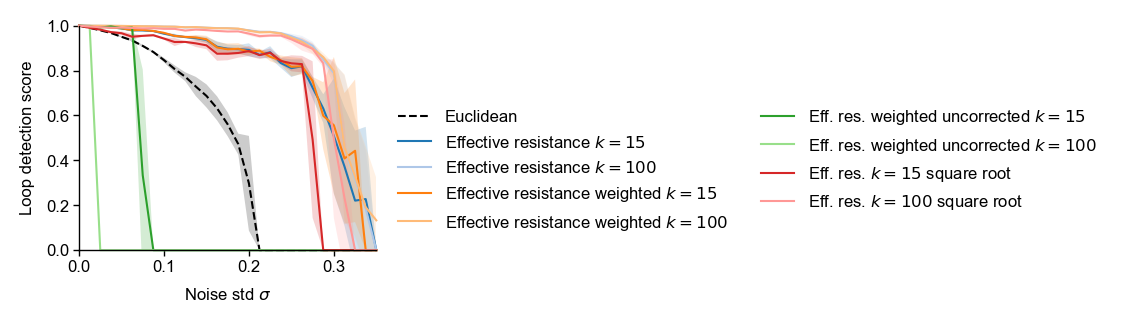

In [28]:
# plot figure
fig, ax = plt.subplots(figsize=(5.5, 1.5))

cmap = plt.get_cmap("tab20")

for i, distance in enumerate(outlier_scores):
    
    for j, dist_str in enumerate(outlier_scores[distance]):
        mean = outlier_scores[distance][dist_str].mean(1)
        std = outlier_scores[distance][dist_str].std(1)
        color = cmap(j) if distance != "euclidean" else "k"
        linestyle = "dashed" if distance == "euclidean" else "solid"
        ax.plot(sigmas,
                mean,
                c=color,
                clip_on=False,
                label=full_dist_to_print[dist_str].replace("\n", " "),
                linestyle=linestyle,
                
                )
        ax.fill_between(sigmas,
                        mean+std,
                        mean-std,
                        alpha=0.2,
                        color=color,
                        edgecolor=None)
        
ax.legend(frameon=False, loc = (1.05, 0.05), ncols=2)
        
ax.set_ylim(0, 1)
ax.set_xlim(0, 0.35)
ax.set_xlabel("Noise std $\sigma$")
ax.set_ylabel("Loop detection score")

fig.savefig(os.path.join(fig_path, "fig_toy_circle_eff_res.pdf"))

# Low perplexity t-SNE

In [29]:
from vis_utils.utils import load_dict
from vis_utils.plot import plot_scatter
from persim import plot_diagrams
from pd_utils import get_persistent_feature_id
from fig_utils import plot_edges_on_scatter

In [30]:
# hyperparameters which produce the best AUC per distance type
distances = {
    "tsne_embd": [
    {"perplexity": 8, "n_epochs": 500, "n_early_epochs": 250, "rescale_tsne": True},    ],
}

n = 1000
embd_dim = 50
sigmas = [0.0, 0.05, 0.1]
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0]


In [31]:
all_res = load_multiple_res(datasets="toy_circle", distances=distances, root_path=root_path, n=n, embd_dims=embd_dim, sigmas=sigmas, seeds=seeds, n_threads=10)

Done with toy_circle 50 tsne_embd_perplexity_8_n_epochs_500_n_early_epochs_250_rescale_tsne_True n_outliers=0


In [32]:
embd_file_names = [
    "tsne_n_1000_d_50_ortho_gauss_sigma_0.0_perplexity_8_n_epochs_500_n_early_epochs_250_seed_0_init_pca_rescale_True.pkl",
    "tsne_n_1000_d_50_ortho_gauss_sigma_0.05_perplexity_8_n_epochs_500_n_early_epochs_250_seed_0_init_pca_rescale_True.pkl",
    "tsne_n_1000_d_50_ortho_gauss_sigma_0.1_perplexity_8_n_epochs_500_n_early_epochs_250_seed_0_init_pca_rescale_True.pkl"
    ]


In [33]:
embeddings = [load_dict(os.path.join(root_path, "toy_circle", embd_file_name))["embds"][-1] for embd_file_name in embd_file_names]

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(3., 1.5))
highlight_colors = [plt.get_cmap("tab10")(i) for i in [2, 5]]
linestyles = ["solid", "dotted"]
letters = "abc"

res = all_res["tsne_embd"]["tsne_embd_perplexity_8_n_epochs_500_n_early_epochs_250_rescale_tsne_True"]
for i, (embd, sigma) in enumerate(zip(embeddings, sigmas)):
    plot_scatter(x=embd, ax=ax[0, i], s=1, y="k", scalebar=False)
    plot_diagrams(res[sigma]["dgms"],
              ax=ax[1, i],
              plot_only=[1], 
              size=5, 
              color="k",
              colormap=style_file, # necessary bc plot_diagrams uses the colormap as mpl style
              )

    
    idx = [get_persistent_feature_id(res[sigma], dim=1, m=m+1) for m in range(2)] 

    for j, index in enumerate(idx):
        plot_edges_on_scatter(ax=ax[0, i],
                         edge_idx = res[sigma]["cycles"][1][index],
                         x=embd,
                         color=highlight_colors[j],
                         linewidth=0.5,
                         linestyle=linestyles[j],
                         )
        
        ax[1, i].scatter(*res[sigma]["dgms"][1][index].T,
                 color=highlight_colors[j],
                 s=7
                 )

    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].legend().remove()
    
    ax[0, i].set_title("$\sigma$ = {}".format(sigma))
    ax[0, i].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)        

    if i > 0:
        ax[1, i].set_ylabel("")
    ax[1, 0].set_ylabel("1D persistence \nDeath")
    ax[0, 0].text(
        fontsize=6,
        x=-0.05,
        y=0.4,
        transform=ax[0,0].transAxes,
        rotation="vertical",
        s="t-SNE")
    

fig.savefig(os.path.join(fig_path, "fig_toy_circle_tsne_embd.pdf"))


## visualization of distances

In [35]:
from utils.dist_utils import  get_dist
from utils.toydata_utils import get_toy_data
from utils.io_utils import dist_kwargs_to_str
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import math

In [36]:
dataset = "toy_circle"
sigma = 0.25
d=50
seed = 0
data = get_toy_data(dataset="toy_circle", n=1000, d=50, gaussian={"sigma":sigma}, seed=seed)
n_dists = len(list(distances.keys()))

In [ ]:
dists = {}
for dist in distances.keys():
    if not dist.endswith("_embd"):
        dists[dist] = get_dist(x=data, distance=dist, **distances[dist][0])
    else:
        dists[dist] = get_dist(x=data,
                               distance=dist, 
                               **distances[dist][0], 
                               root_path=os.path.join(root_path, dataset),
                               dataset=f"n_{n}_d_{d}_ortho_gauss_sigma_{sigma}")

In [ ]:
pca = PCA(n_components=2).fit_transform(data)

mds = {dist: MDS(2, eps=1e-6, max_iter=6000, dissimilarity="precomputed").fit_transform(dists[dist]) for dist in dists.keys()}

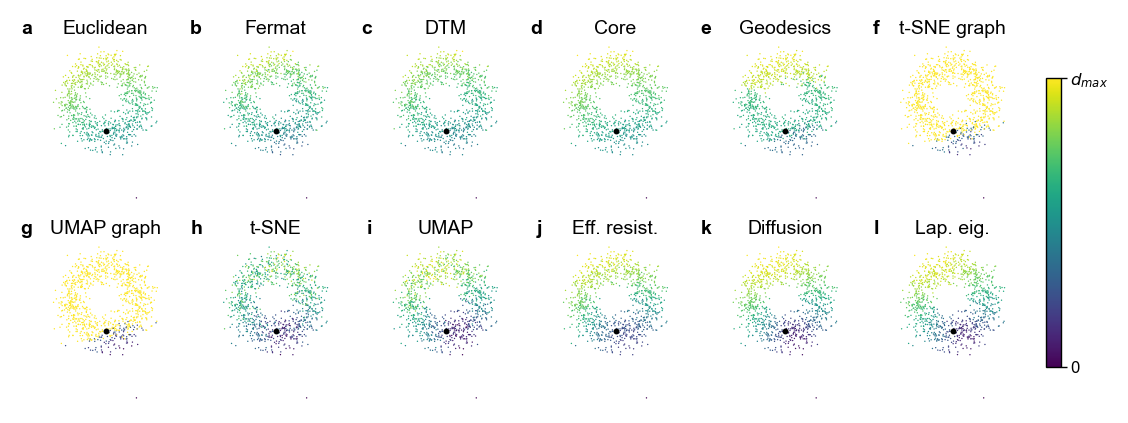

In [210]:
ncols = 6
fig, ax = plt.subplots(ncols=ncols, nrows=n_dists // ncols, figsize=(5.5, 2))
letters = "abcdefghijklmnopqrstuvwxyz"
point_id = 3

theta = -np.arccos((pca[point_id] / np.linalg.norm(pca[point_id])).dot(np.array([0, 1]))) + np.pi
rot = np.array([[np.cos(theta), -np.sin(theta)], 
                     [np.sin(theta), np.cos(theta)]])

pca_rot = pca @ rot
for i, dist in enumerate(dists.keys()):
    r, c = i // ncols, i % ncols
    scatter = plot_scatter(ax[r, c], x=pca_rot, y=dists[dist][0], cmap="viridis", scalebar=False, alpha=1)
    ax[r, c].scatter(*pca_rot[point_id], s=5, c="k")
    ax[r, c].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
    )
    ax[r, c].set_title(dist_to_print[dist])
cbar= fig.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02 )
cbar.ax.set_yticks([0, scatter.get_clim()[1]]) 

cbar.ax.set_yticklabels(["0", "$d_{max}$"]) 

fig.savefig(os.path.join(fig_path, "fig_toy_circle_distances_pca.pdf"))

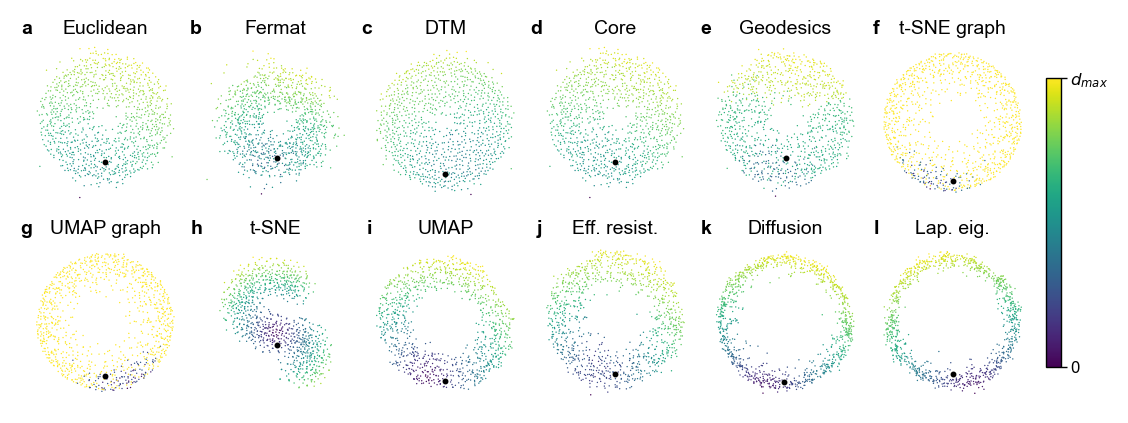

In [211]:
ncols = 6
fig, ax = plt.subplots(ncols=ncols, nrows=n_dists // ncols, figsize=(5.5, 2))
letters = "abcdefghijklmnopqrstuvwxyz"
point_id = 3




for i, dist in enumerate(dists.keys()):
    r, c = i // ncols, i % ncols
    
    theta = - math.atan2(*mds[dist][point_id]) + np.pi
    rot = np.array([[np.cos(theta), -np.sin(theta)], 
                         [np.sin(theta), np.cos(theta)]])
    
    mds_rot = mds[dist] @ rot
    
    scatter = plot_scatter(ax[r, c], x=mds_rot, y=dists[dist][0], cmap="viridis", scalebar=False, alpha=1)
    ax[r, c].scatter(*mds_rot[point_id], s=5, c="k")
    ax[r, c].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
    )
    ax[r, c].set_title(dist_to_print[dist])
cbar= fig.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02 )
cbar.ax.set_yticks([0, scatter.get_clim()[1]]) 

cbar.ax.set_yticklabels(["0", "$d_{max}$"]) 

fig.savefig(os.path.join(fig_path, "fig_toy_circle_distances_mds.pdf"))